In [ ]:
# Import libraries and read in datasets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import warnings


plt.style.use('seaborn')
warnings.filterwarnings('ignore')



<ipython-input-1-317b92258c91>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/amazon_reviews_multilingual_US_v1_00.tsv"

apr = pd.read_csv(path,
                       sep='\t', error_bad_lines=False, warn_bad_lines=False)

In [ ]:
# Find out how many downvotes each review received
apr['downvotes'] = apr.total_votes - apr.helpful_votes

# Reorder columns
columns = ['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'downvotes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date']

apr = apr[columns]

# Standardized product category names
apr.product_category.replace({
        'Digital_Music_Purchase': 'Digital Music Purchase',
        'Digital_Ebook_Purchase': 'Digital eBook Purchase',
        'Digital_Video_Download': 'Digital Video Download',
        'Lawn and Garden': 'Lawn & Garden',
        'Mobile_Electronics': 'Mobile Electronics',
        'Personal_Care_Appliances': 'Personal Care Appliances',
        'Mobile_Apps': 'Mobile Apps'
    }, inplace=True)

In [ ]:
# Many lost unique product ids were actually small variations of the same product
apr.groupby('product_parent')['product_title'].value_counts()[12:20]

product_parent  product_title                                                        
896923          For Whom The Bell Tolls                                                  8
                FOR WHOM THE BELL TOLLS                                                  5
                For Whom the Bell Tolls (War Promo)                                      2
                FOR WHOM THE BELL TOLLS ~1940 BOOK CLUB EDITION                          1
                For Whom The Bell Tolls (Turtleback School & Library Binding Edition)    1
                For Whom the Bell Tolls (Illustrated)                                    1
                For Whom the Bell Tolls (Scribner Classic)                               1
                For Whom the Bell Tolls (The Scribner Library)                           1
Name: product_title, dtype: int64

In [ ]:
# Extract counts on how many customers purchased a unique product
purchased_counts = apr.product_id.value_counts().rename('purchased_counts')

# Add column containing product purchased counts
apr = apr.merge(purchased_counts.to_frame(),
                left_on='product_id',
                right_index=True)

# Filter only products with 100 or more purchases
apr = apr[apr.purchased_counts >= 100]

In [ ]:
print(apr.groupby('product_parent')['product_id'].value_counts()[1:3])
print('\n')
print(apr.groupby('product_parent')['product_title'].value_counts()[1:3])
print('\n')
print(apr.groupby('product_parent')['product_category'].value_counts()[1:3])

product_parent  product_id
896923          0684803356    329
                B000FC0OOU    211
Name: product_id, dtype: int64


product_parent  product_title                              
896923          For Whom the Bell Tolls                        329
                For Whom the Bell Tolls (Scribner Classics)    211
Name: product_title, dtype: int64


product_parent  product_category      
896923          Books                     329
                Digital eBook Purchase    211
Name: product_category, dtype: int64


In [ ]:
example = apr[apr.product_parent == 382448153]
example.groupby('product_parent')['product_title'].value_counts()

product_parent  product_title                                                   
382448153       The Girl Who Kicked the Hornet's Nest (Millennium Series Book 3)    1804
                The Girl Who Played with Fire (Millennium Series Book 2)            1569
                The Girl Who Kicked the Hornet's Nest (Millennium Trilogy)          1093
                The Girl Who Played with Fire (Millennium Series)                   1091
                The Girl Who Played with Fire (Millennium )                          455
                The Girl Who Kicked the Hornet's Nest                                304
                The Girl Who Kicked the Hornets' Nest (Millennium Series Book 3)     199
                The Girl Who Kicked the Hornet's Nest (Millennium Series)            168
                The Girl Who Played With Fire (Millennium Series)                    152
Name: product_title, dtype: int64

In [ ]:
apr.dropna(axis=0, inplace=True)

# Reset index and drop unimportant columns
apr = apr.reset_index().drop(['index', 'marketplace', 'vine'], axis=1)

def missing(dataset):
    columns = dataset.columns
    print('MISSING ROWS per COLUMN')
    for column in columns:
        percentage = (dataset[column].isnull().sum() / len(dataset)) * 100
        print('{}: {}, {:0.2f}%'.format(column, dataset[column].isnull().sum(), percentage))

missing(apr)

MISSING ROWS per COLUMN
customer_id: 0, 0.00%
review_id: 0, 0.00%
product_id: 0, 0.00%
product_parent: 0, 0.00%
product_title: 0, 0.00%
product_category: 0, 0.00%
star_rating: 0, 0.00%
helpful_votes: 0, 0.00%
downvotes: 0, 0.00%
total_votes: 0, 0.00%
verified_purchase: 0, 0.00%
review_headline: 0, 0.00%
review_body: 0, 0.00%
review_date: 0, 0.00%
purchased_counts: 0, 0.00%


In [ ]:
# Split review dates by year, month and day (strings)
time_split = apr.review_date.str.split('-', n=2, expand=True)
apr['year'] = time_split[0]
apr['month'] = time_split[1]
apr['day'] = time_split[2]

# Convert review dates into a datetime object
dates = apr.review_date
apr.review_date = [d.date() for d in pd.to_datetime(dates)]

# Extract month and year from review dates
apr['month_year'] = pd.to_datetime(apr['review_date']).dt.to_period('M')

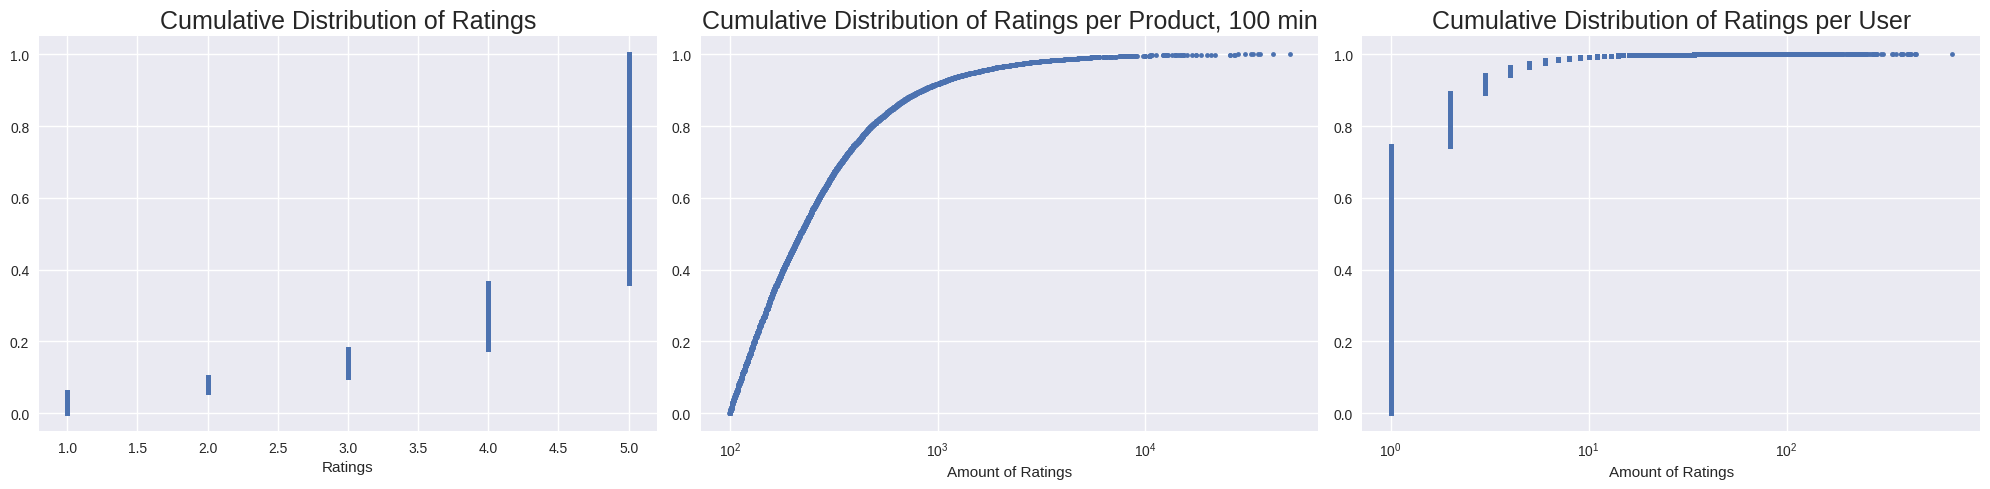

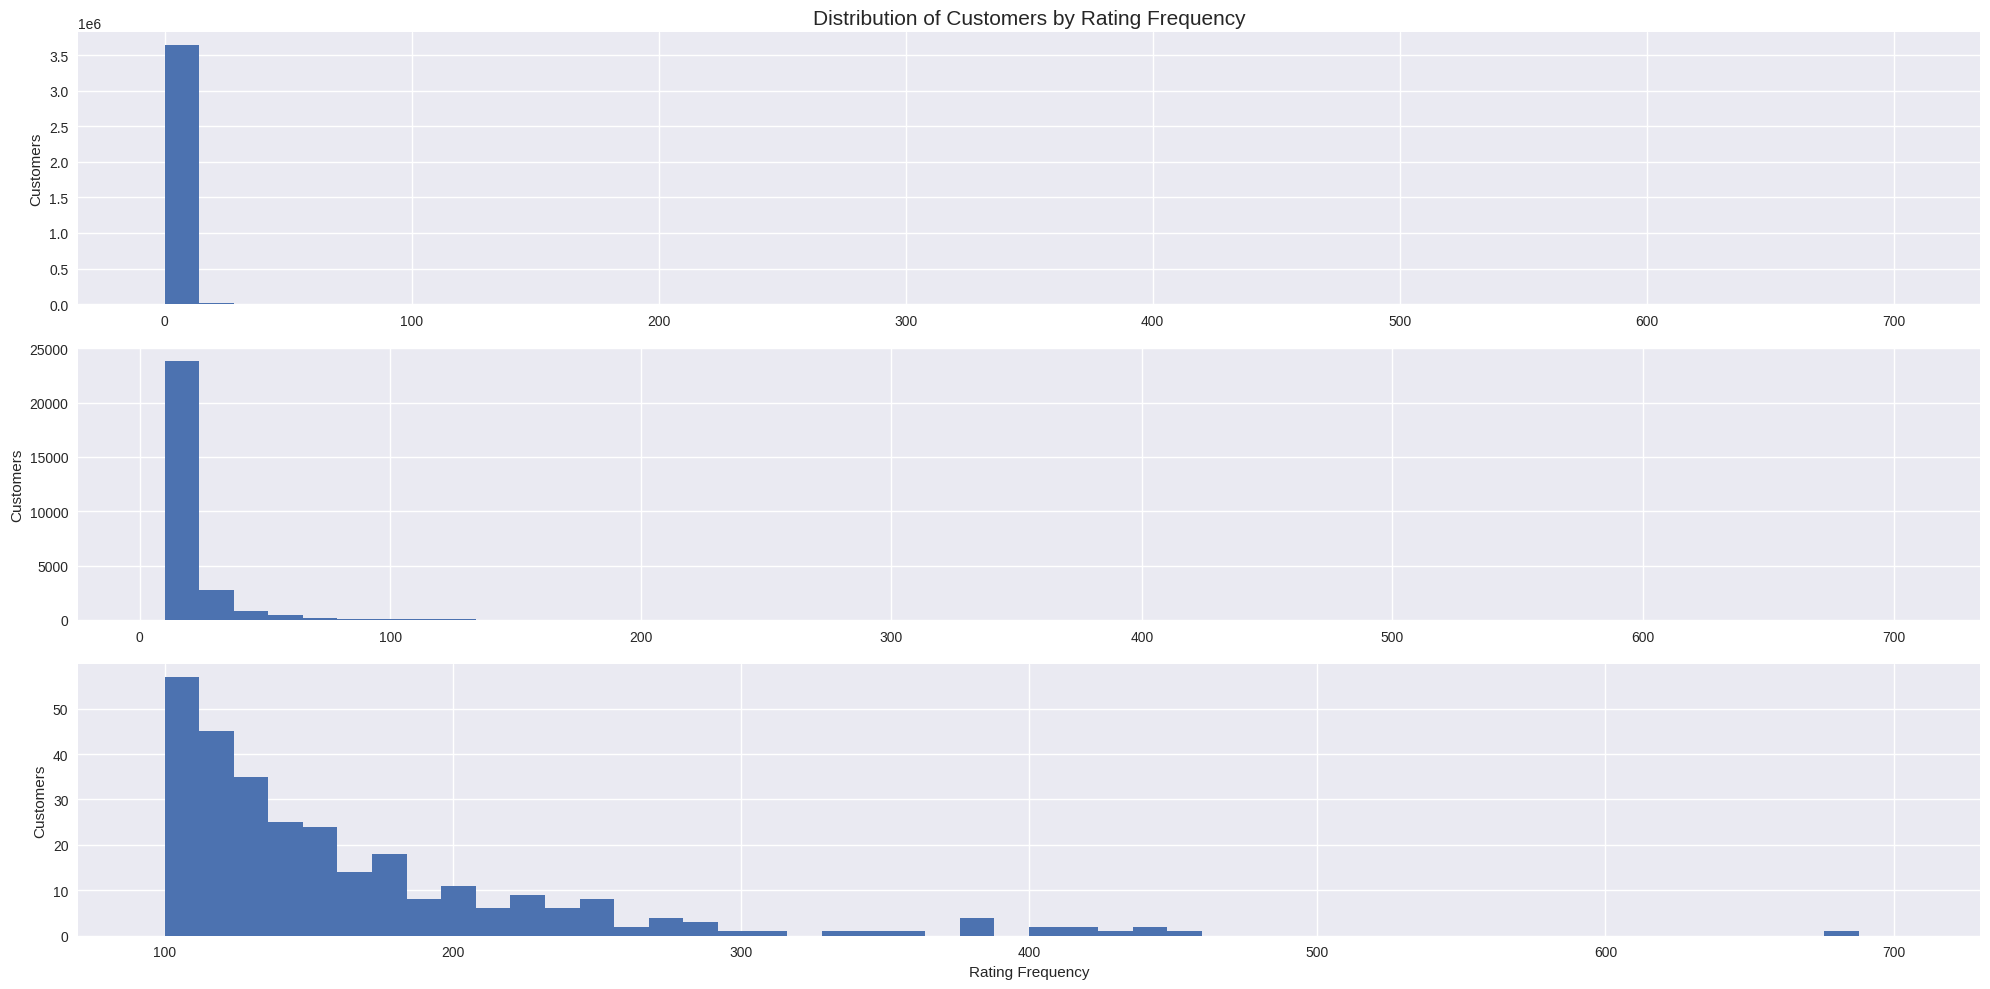

In [ ]:
# Empirical cumulative distribution functions
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return x, y

plt.figure(figsize=(20,5))

# Plot cumulative distribution of ratings
x, y = ecdf(apr.star_rating)

ax1 = plt.subplot(1,3,1)
ax1.set_xlabel('Ratings')
ax1.set_title('Cumulative Distribution of Ratings', fontsize=18)
plt.plot(x, y, marker='.', linestyle='none')


# Plot cumulative distribution of ratings per product, 100 minimum
x, y = ecdf(apr.groupby('product_id').star_rating.count())

ax2 = plt.subplot(1,3,2)
ax2.set_xlabel('Amount of Ratings')
ax2.plot(x, y, marker='.', linestyle='none')
ax2.set_xscale('log');
ax2.set_title('Cumulative Distribution of Ratings per Product, 100 min', fontsize=18)


# Plot cumulative distribution of ratings per user
x, y = ecdf(apr.groupby('customer_id').star_rating.count())

ax3 = plt.subplot(1,3,3)
ax3.set_xlabel('Amount of Ratings')
ax3.plot(x, y, marker='.', linestyle='none')
ax3.set_xscale('log');
ax3.set_title('Cumulative Distribution of Ratings per User', fontsize=18)

sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

# Plot distribution of amount of ratings per user
plt.figure(figsize=(20,10))

ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2)
ax3 = plt.subplot(3,1,3)

apr.customer_id.value_counts().plot(kind='hist', bins=50, range=(0,700), ax=ax1)
apr.customer_id.value_counts().plot(kind='hist', bins=50, range=(10,700), ax=ax2)
apr.customer_id.value_counts().plot(kind='hist', bins=50, range=(100,700), ax=ax3)

ax1.set_title('Distribution of Customers by Rating Frequency', fontsize=15)
ax1.set_ylabel('Customers')
ax2.set_ylabel('Customers')
ax3.set_ylabel('Customers')
ax3.set_xlabel('Rating Frequency')

sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

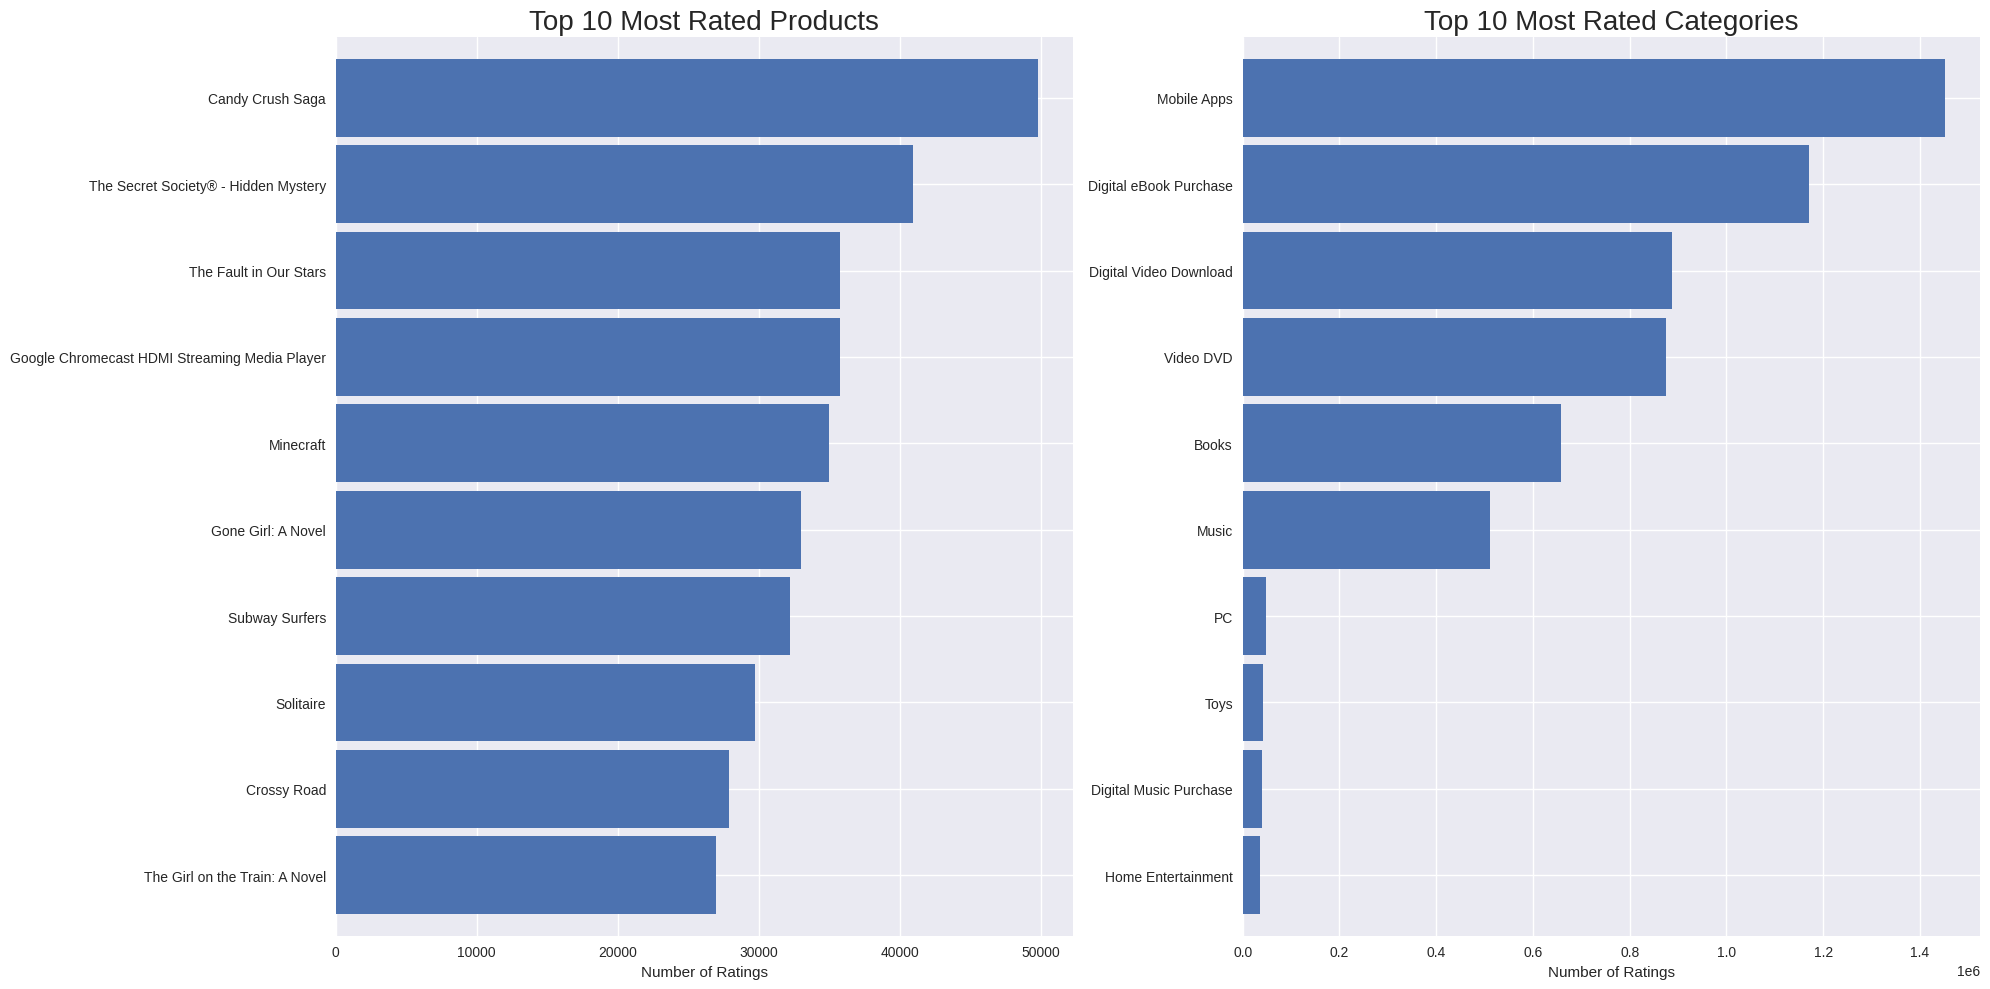

In [ ]:
plt.figure(figsize=(20,10))

# Plot 10 most common products purchased
ax1 = plt.subplot(1,2,1)
apr.product_title.value_counts()[:10].sort_values().plot(kind='barh', width=0.9, ax=ax1)
ax1.set_xlabel('Number of Ratings')
ax1.set_title('Top 10 Most Rated Products', fontsize=20)

# Plot 10 most common categories purchased
ax2 = plt.subplot(1,2,2)
apr.product_category.value_counts()[:10].sort_values().plot(kind='barh', width=0.9, ax=ax2)
ax2.set_xlabel('Number of Ratings')
ax2.set_title('Top 10 Most Rated Categories', fontsize=20)

sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

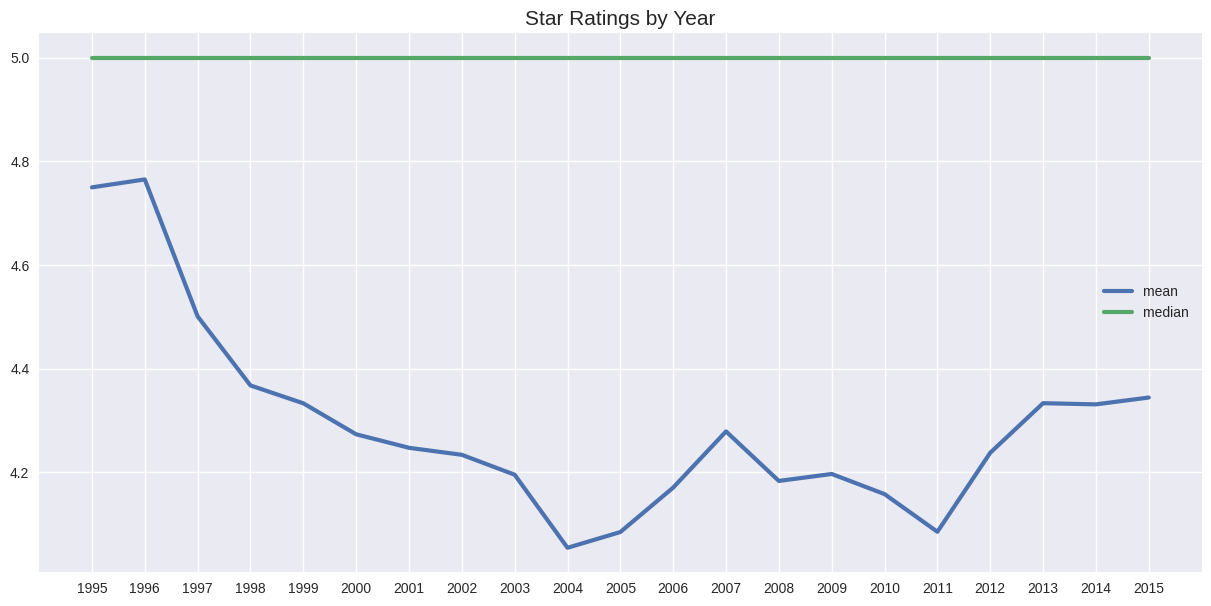

Last recorded rating was on 2015-08-31


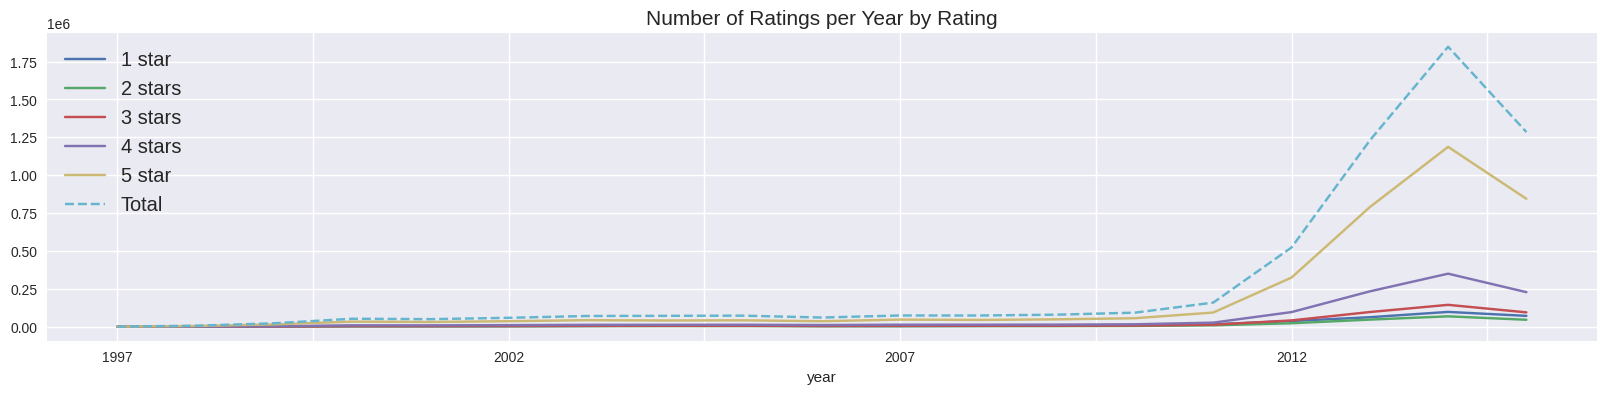

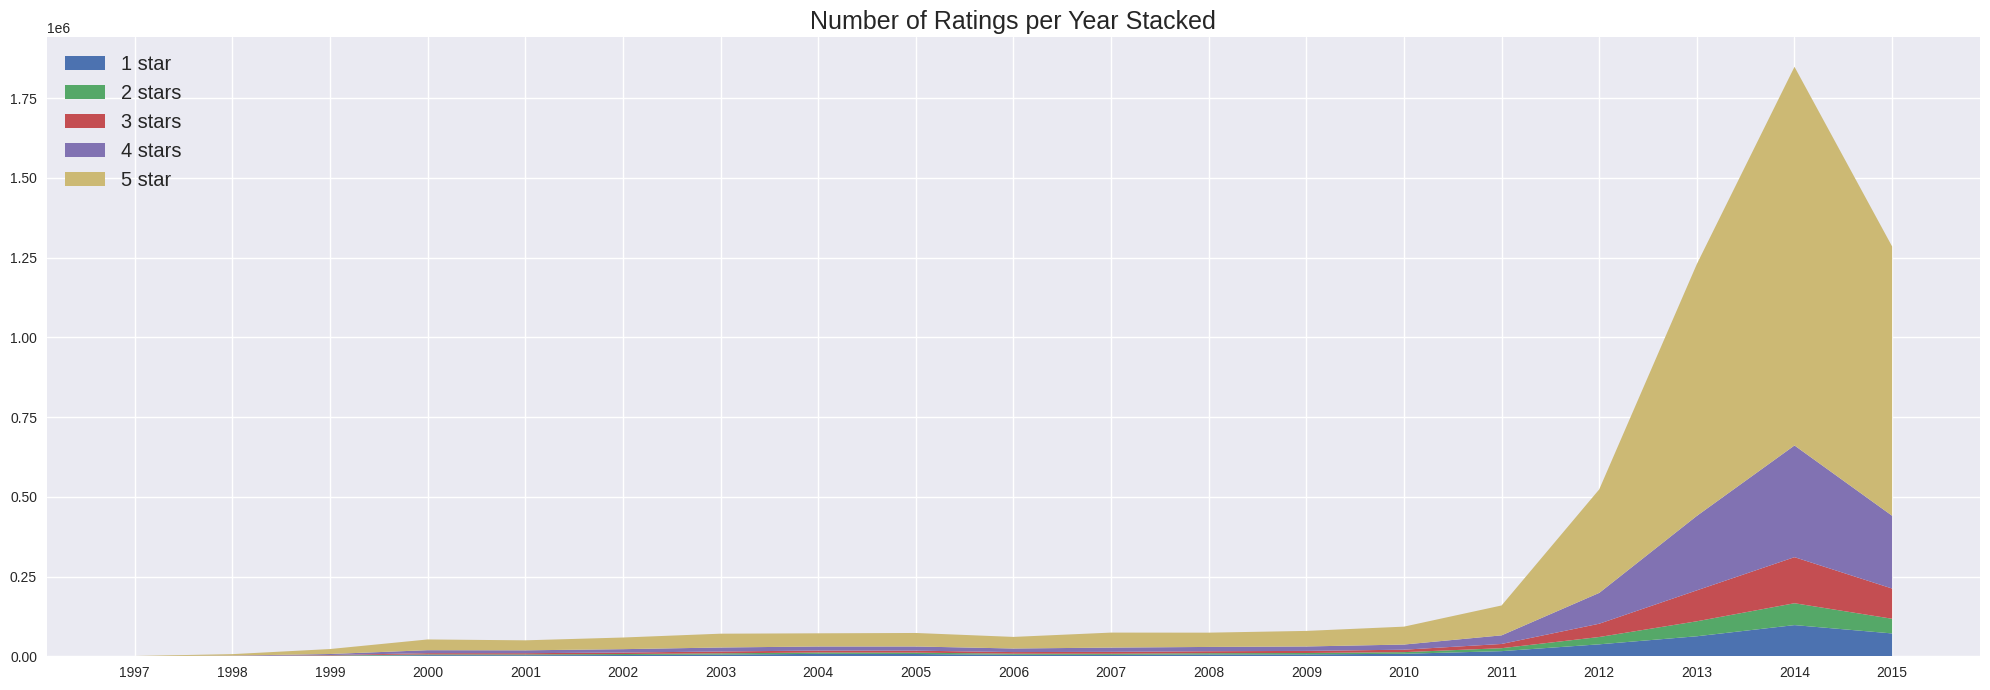

In [ ]:
plt.figure(figsize=(15,7))
# Plot average star ratings by year
plt.plot('year', 'star_rating', data=apr.groupby('year').mean().reset_index().sort_values('year'), linewidth=3)

# Plot median star ratings by year
plt.plot('year', 'star_rating', data=apr.groupby('year').median().reset_index().sort_values('year'), linewidth=3)

plt.legend(['mean', 'median'], loc='right')
plt.title('Star Ratings by Year', fontsize = 15)
sns.despine(top=True, right=True)
plt.show()

plt.figure(figsize=(20,4))

# Find last rating date
print('Last recorded rating was on {}'.format(apr.review_date.tail(1).iloc[0]))

# Make sure all ratings have the same time frame
time = ['1997', '1998', '1999', '2000', '2001', '2002', '2003',
       '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015']

# Separate ratings
one = apr[apr.star_rating == 1.0]
two = apr[apr.star_rating == 2.0]
three = apr[apr.star_rating == 3.0]
four = apr[apr.star_rating == 4.0]
five = apr[apr.star_rating == 5.0]

# Plot number of ratings per year per rating
one.groupby('year').count().star_rating[1:].plot()
two.groupby('year').count().star_rating[1:].plot()
three.groupby('year').count().star_rating.plot()
four.groupby('year').count().star_rating[2:].plot()
five.groupby('year').count().star_rating[2:].plot()

# Plot number of ratings per year
plt.plot(apr.groupby('year').count().star_rating[2:], linestyle='--')
plt.title('Number of Ratings per Year by Rating', fontsize=15)

plt.legend(['1 star', '2 stars', '3 stars', '4 stars', '5 star', 'Total'], loc='upper left', fontsize='x-large')
sns.despine(top=True, right=True)
plt.show()

# Plot number of ratings per year per rating
plt.figure(figsize=(20,7))
plt.stackplot(time,
              one.groupby('year').count().star_rating[1:],
              two.groupby('year').count().star_rating[1:],
              three.groupby('year').count().star_rating,
              four.groupby('year').count().star_rating[2:],
              five.groupby('year').count().star_rating[2:])
plt.title('Number of Ratings per Year Stacked', fontsize=18)

plt.legend(['1 star', '2 stars', '3 stars', '4 stars', '5 star'], loc='upper left', fontsize='x-large')
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

In [ ]:
S